# Gas Price Data Exploration
===

I compare a variety of machine learning regression algorithms to determine which will perform the best with the gas price data from the EIA.

In [13]:
#Load libraries and tools
library("devtools")
library("AzureML")
library("httr")
library("RCurl")
library("jsonlite")
library("XML")
install.packages(c("caret","corrplot"))
library("caret")
library("corrplot")
install.packages(c("e1071","cowplot","gbm"))
library(e1071)
library(ggplot2)
library(cowplot)
library(plyr)
library(gbm)
library(reshape)

Installing packages into '/home/nbcommon/R'
(as 'lib' is unspecified)



The downloaded source packages are in
	'/tmp/RtmpLp6kCM/downloaded_packages'


Installing packages into '/home/nbcommon/R'
(as 'lib' is unspecified)



The downloaded source packages are in
	'/tmp/RtmpLp6kCM/downloaded_packages'


I use a helper function to load in data from the Azure Blob Storage location.

In [14]:
#This function simplifies calls to the Azure Blob Storage containers to read and put data
azureBlobCall <- function(url, verb, key, requestBody=NULL, headers=NULL, ifMatch="", md5="", ...) { 
  urlcomponents <- httr::parse_url(url)
  account <- gsub(".blob.core.windows.net", "", urlcomponents$hostname, fixed = TRUE)
  container <- urlcomponents$path

  # get timestamp in us locale
  lct <- Sys.getlocale("LC_TIME"); Sys.setlocale("LC_TIME", "us")
  `x-ms-date` <- format(Sys.time(),"%a, %d %b %Y %H:%M:%S %Z", tz="GMT")
  Sys.setlocale("LC_TIME", lct)

  # if requestBody exist get content length in bytes and content type
  `Content-Length` <- ""; `Content-Type` <- ""
  if(!is.null(requestBody)) {
    if(class(requestBody) == "form_file") {
      `Content-Length` <- (file.info(requestBody$path))$size
      `Content-Type` <- requestBody$type 
    } else {
      requestBody <- enc2utf8(as.character(requestBody))
      `Content-Length` <- nchar(requestBody, "bytes")
      `Content-Type` <- "text/plain; charset=UTF-8" 
    }
  } 

  # combine timestamp and version headers with any input headers, order and create the CanonicalizedHeaders
  headers <- setNames(c(`x-ms-date`, "2015-04-05",  unlist(headers)), 
                      c("x-ms-date", "x-ms-version", unclass(names(unlist(headers)))))
  headers <- headers[order(names(headers))]
  CanonicalizedHeaders <- paste(names(headers), headers, sep=":", collapse = "\n")

  # create CanonicalizedResource headers and add any queries to it
  if(!is.null(urlcomponents$query)) {
    components <- setNames(unlist(urlcomponents$query), unclass(names(unlist(urlcomponents$query))))
    componentstring <- paste0("\n", paste(names(components[order(names(components))]),
                                          components[order(names(components))], sep=":", collapse = "\n"))
  } else componentstring <- ""
  CanonicalizedResource <- paste0("/",account,"/",container, componentstring)

  # create the authorizationtoken
  signaturestring <- paste0(verb, "\n\n\n", `Content-Length`, "\n", md5, "\n", `Content-Type`, "\n\n\n", 
                            ifMatch, "\n\n\n\n", CanonicalizedHeaders, "\n", CanonicalizedResource)

  requestspecificencodedkey <- RCurl::base64(
    digest::hmac(key=RCurl::base64Decode(key, mode="raw"),
                 object=enc2utf8(signaturestring),
                 algo= "sha256", raw=TRUE)
  )

  authorizationtoken <- paste0("SharedKey ", account, ":", requestspecificencodedkey)

  # make the call
  headers_final <- add_headers(Authorization=authorizationtoken, headers, `Content-Type` = `Content-Type`)
  call <- httr::VERB(verb=verb, url=url, config=headers_final, body=requestBody, verbose())

  #print("signaturestring");print(signaturestring); 
  #print(headers_final); print(call)
  return(content(call,type="text/csv",header=FALSE))
} 


We first load the training US EIA data. Then we add column labels and adjust the metadata.

In [15]:
key <- "<private access key>"
trainfeatures<-azureBlobCall("https://blobstorageaccount.blob.core.windows.net/blobstoragecontainer/old_trainfeatures.txt/part-r-00000", 
                       "GET", key)
names(trainfeatures)<-c("Date","Week","CrudePrice","GasStock","DaySupply","GasImports","RefinerPerc","OilExports","OilImports")
trainfeatures$Date <- as.Date(trainfeatures$Date)

trainvalues<-azureBlobCall("https://blobstorageaccount.blob.core.windows.net/blobstoragecontainer/old_trainvalues.txt/part-r-00000", 
                       "GET", key)
names(trainvalues)<-c("Date","GasDate","GasPrice")
trainvalues$Date <- as.Date(trainvalues$Date)
trainvalues$GasDate <- as.Date(trainvalues$GasDate)

str(trainfeatures)
str(trainvalues)

Warning message:
In Sys.setlocale("LC_TIME", "us"): OS reports request to set locale to "us" cannot be honoredWarning message:
In Sys.setlocale("LC_TIME", "us"): OS reports request to set locale to "us" cannot be honored

'data.frame':	1081 obs. of  9 variables:
 $ Date       : Date, format: "1994-11-23" "1994-12-02" ...
 $ Week       : int  47 48 49 50 51 52 1 2 3 4 ...
 $ CrudePrice : num  17.7 17.8 17 16.9 17.1 ...
 $ GasStock   : int  168748 173223 172344 171935 168641 170102 172617 174547 175522 177741 ...
 $ DaySupply  : num  27.7 28.3 27.2 27.3 26.3 26.2 27.5 28.1 29.3 30.5 ...
 $ GasImports : int  170 176 368 248 285 284 110 274 178 186 ...
 $ RefinerPerc: num  95.3 95 91.8 92.9 92.8 93.9 95.3 92.7 90.4 88.8 ...
 $ OilExports : int  101 98 98 98 98 99 100 100 100 101 ...
 $ OilImports : int  7161 6224 7030 7222 6566 7334 7136 6442 6521 6465 ...
'data.frame':	1081 obs. of  3 variables:
 $ Date    : Date, format: "1994-11-23" "1994-12-02" ...
 $ GasDate : Date, format: "1994-11-28" "1994-12-05" ...
 $ GasPrice: num  1.18 1.14 1.12 1.1 1.09 ...


Now we load the final test data to see how our models do.

In [16]:
testfeatures<-azureBlobCall("https://blobstorageaccount.blob.core.windows.net/blobstoragecontainer/old_testfeatures.txt/part-r-00000", 
                       "GET", key)
names(testfeatures)<-c("Date","Week","CrudePrice","GasStock","DaySupply","GasImports","RefinerPerc","OilExports","OilImports")
testfeatures$Date <- as.Date(testfeatures$Date)

testvalues<-azureBlobCall("https://blobstorageaccount.blob.core.windows.net/blobstoragecontainer/old_testvalues.txt/part-r-00000", 
                       "GET", key)
names(testvalues)<-c("Date","GasDate","GasPrice")
testvalues$Date <- as.Date(testvalues$Date)
testvalues$GasDate <- as.Date(testvalues$GasDate)

Warning message:
In Sys.setlocale("LC_TIME", "us"): OS reports request to set locale to "us" cannot be honoredWarning message:
In Sys.setlocale("LC_TIME", "us"): OS reports request to set locale to "us" cannot be honored


Now we join the two data frames together to do predictions.

In [17]:
#Join the two data frames together
traindata<- join(trainfeatures,trainvalues,by="Date",type="left")
testdata<- join(testfeatures,testvalues,by="Date",type="left")

head(traindata)


,Date,Week,CrudePrice,GasStock,DaySupply,GasImports,RefinerPerc,OilExports,OilImports,GasDate,GasPrice
1,1994-11-23,47,17.72667,168748,27.7,170,95.3,101,7161,1994-11-28,1.175
2,1994-12-02,48,17.78,173223,28.3,176,95,98,6224,1994-12-05,1.143
3,1994-12-09,49,16.986,172344,27.2,368,91.8,98,7030,1994-12-12,1.118
4,1994-12-16,50,16.86,171935,27.3,248,92.9,98,7222,1994-12-19,1.099
5,1994-12-23,51,17.104,168641,26.3,285,92.8,98,6566,1994-12-26,1.088
6,1994-12-30,52,17.7075,170102,26.2,284,93.9,99,7334,1995-01-02,1.104


# Visualizing the data

The next step is to visualize the data. Because we have a time series, we'll look at all of the training features together. Non-random values may indicate that the dataset will be helpful in predicting the final gas price.

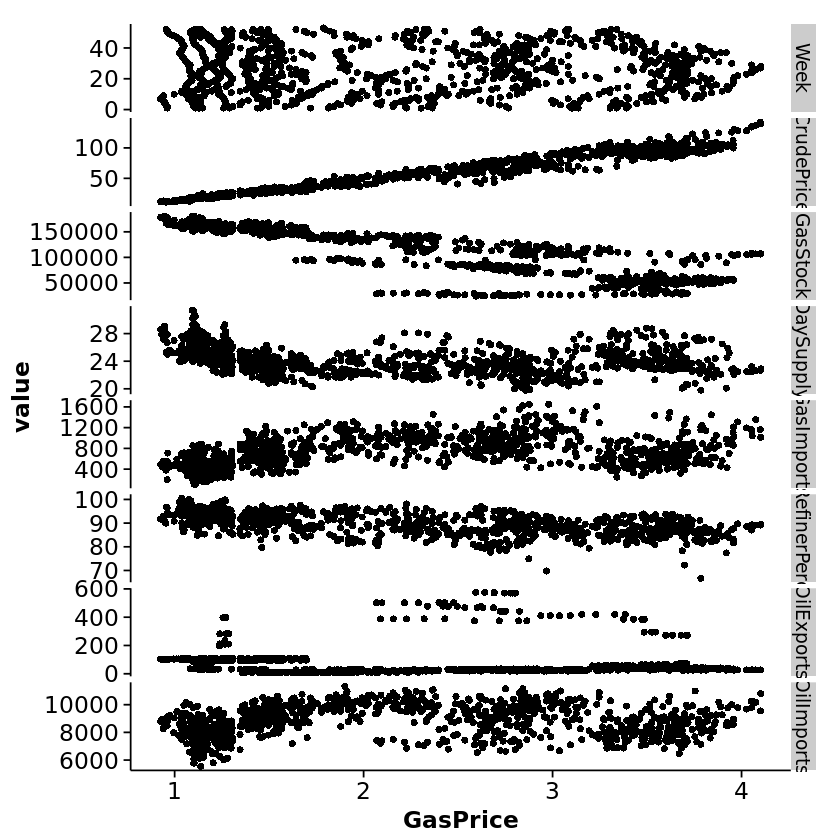

In [18]:
dfmd <- subset(traindata,select=-c(Date,GasDate))
df<-melt(dfmd, id.vars='GasPrice')
#ggplot(df, aes(price,y=value,color=variable))+geom_point()
ggplot(df,aes(GasPrice,y=value))+geom_point()+facet_grid(variable ~. ,scales="free_y")

It looks like there are some strong correlations here. We look more specifically to see if any of the datasets are strongly correlated with each other.

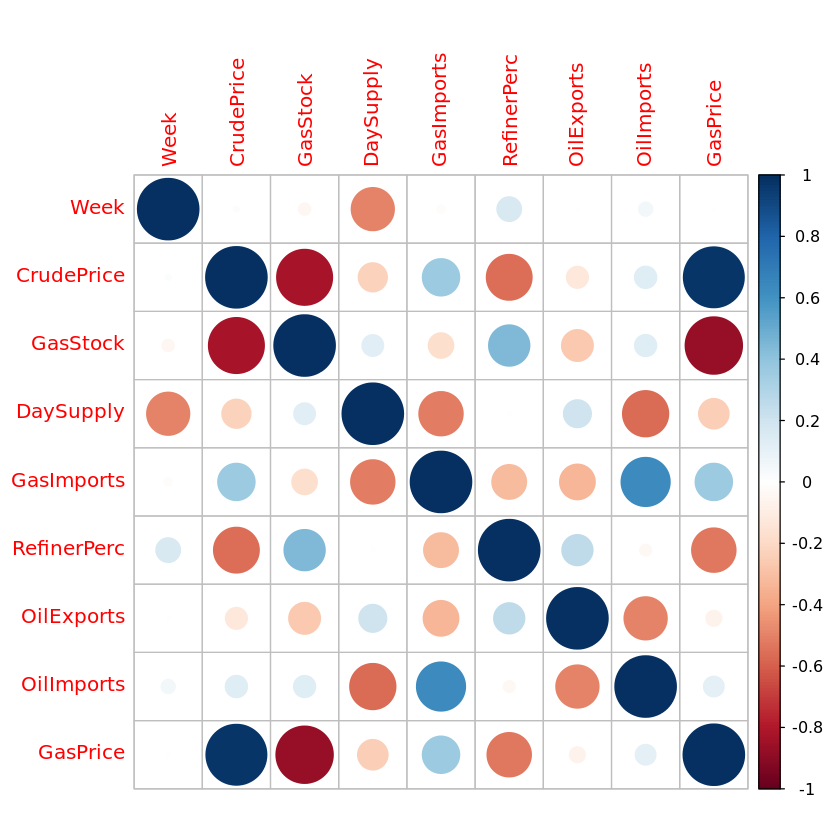

In [19]:
correlationMatrix <- cor(dfmd)
corrplot(correlationMatrix)

It looks like there are some strong correlations and a couple of strong anti-correlations. We'll keep all the datasets for now and see how the predictions look.


# Training the Model

We'll try a couple of different models to see how well they perform at predicting the gas prices.

## Models - Linear Regression

Start with a simple linear regression to see how it does.

We split the training data into two parts: we'll train on 80% of the data and use the remaining 20% to validate our training model.

We will also plot the training values, the in-sample testing values, and how well the model is doing predictions in-sample.


Call:
lm(formula = GasPrice ~ . - Date - GasDate, data = trainsubdata)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46256 -0.08965 -0.01795  0.06537  0.65125 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.489e+00  2.007e-01   7.420 2.81e-13 ***
Week        -3.637e-03  4.192e-04  -8.675  < 2e-16 ***
CrudePrice   2.338e-02  3.899e-04  59.971  < 2e-16 ***
GasStock    -4.662e-06  2.673e-07 -17.440  < 2e-16 ***
DaySupply   -2.804e-02  4.164e-03  -6.733 3.04e-11 ***
GasImports   4.490e-05  2.616e-05   1.716   0.0865 .  
RefinerPerc  9.718e-03  1.497e-03   6.491 1.45e-10 ***
OilExports  -3.080e-04  7.372e-05  -4.179 3.23e-05 ***
OilImports  -1.248e-05  7.137e-06  -1.749   0.0806 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1457 on 856 degrees of freedom
Multiple R-squared:  0.9758,	Adjusted R-squared:  0.9755 
F-statistic:  4307 on 8 and 856 DF,  p-value: < 2.2e-16


[1] "RMS Deviation: $ 0.15"


Warning message:
In loop_apply(n, do.ply): Removed 172 rows containing missing values (stat_smooth).Warning message:
In loop_apply(n, do.ply): Removed 172 rows containing missing values (geom_point).

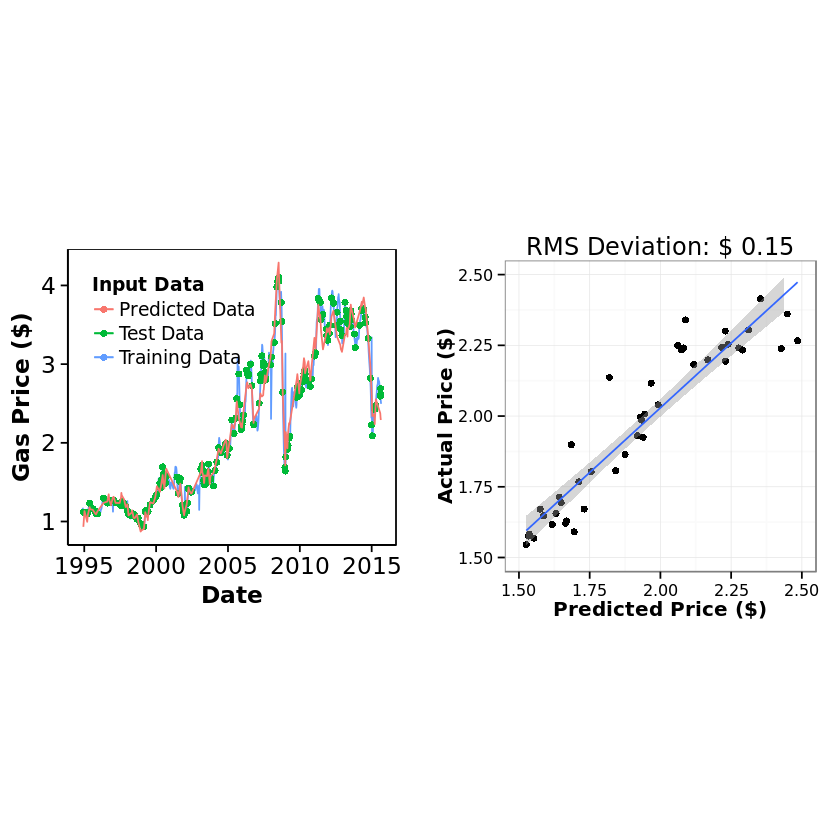

In [65]:
#split the training data into a train and !train (test) sets
train <- createDataPartition(traindata$GasPrice,p=0.8,times=1,list=FALSE)

#Train the model
trainsubdata <-traindata[train,]
lm_model <- lm( GasPrice~.-Date-GasDate, data=trainsubdata)

#Look at the model outputs
summary(lm_model)

#Predict the values for our test data
testsubdata<-traindata[-train,]
lm_predictedY <- predict(lm_model, testsubdata)

#Sore the data as a mean squared difference
lm_score<-sqrt(mean((testsubdata$GasPrice-lm_predictedY)^2))
print(paste("RMS Deviation: $",sprintf("%.2f",lm_score)))


#Plot the model preditction to see how it looks
predData<-data.frame(testsubdata$Date,lm_predictedY)
colnames(predData)<-c("Date","GasPrice")

p1<-ggplot(trainsubdata,aes(Date,GasPrice))+geom_line(aes(color="Training Data"))+
  geom_point(data=testsubdata,aes(color="Test Data"))+
  labs(color="Input Data")+
  geom_line(data=predData,aes(color="Predicted Data"))+
  theme(legend.position=c(.3, .75),panel.border = element_rect(fill=NA,color="black", size=0.5, 
                                    linetype="solid"))+ 
  coord_fixed(ratio=2000)+xlab("Date")+ylab("Gas Price ($)")
  
predVact<-data.frame(testsubdata$GasPrice,predData$GasPrice)
colnames(predVact)<-c("pp","ap")
p2<-ggplot(predVact,aes(x=pp,y=ap))+geom_point()+ ylim(1.5,2.5)+ xlim(1.5,2.5)+
    geom_smooth(method=lm,   # Add linear regression line
                se=TRUE)+theme_bw()+    # Don't add shaded confidence region
    xlab("Predicted Price ($)") + ylab("Actual Price ($)")+ coord_fixed()+
    ggtitle(paste("RMS Deviation: $",sprintf("%.2f",lm_score)))

plot_grid(p1,p2)


We are using the RMS deviation as our metric for model performance. The smaller the deviation, the closer the model predicts the data.

### Out-of-sample Performance

We'll now train the model on all of the training data and use that model to predict the test data- the gas prices for the last couple of months in the dataset. We'll evaluate the model and plot the residuals and the RMS deviation.


[1] "RMS Deviation: $0.09"


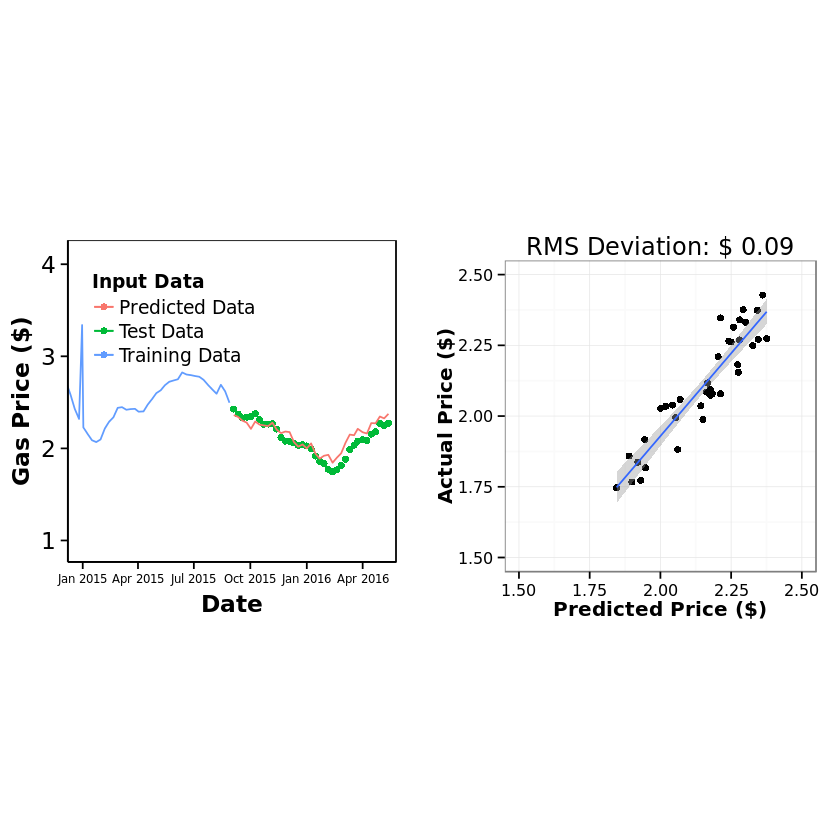

In [134]:
finalmodel <- lm(GasPrice~.-Date-GasDate, data=traindata)

finalpredictedPrice <- predict(finalmodel, testdata)

finalpredtestData<-data.frame(testdata$Date,finalpredictedPrice)
colnames(finalpredtestData) <-c("Date","GasPrice")

p1<-ggplot(traindata,aes(Date,GasPrice))+geom_line(aes(color="Training Data"))+
  geom_point(data=testdata,aes(color="Test Data"))+
  labs(color="Input Data")+
  geom_line(data=finalpredtestData,aes(color="Predicted Data"))+
  theme(legend.position=c(.3, .75),panel.border = element_rect(fill=NA,color="black", size=0.5, 
                                    linetype="solid"),axis.text.x = element_text(size=7))+ 
  coord_fixed(ratio=150)+xlab("Date")+ylab("Gas Price ($)")+ 
  scale_x_date(limits=as.Date(c('2015-01-01','2016-05-01'),breaks=date_breaks(width="6 months")))

finalscore<-sqrt(mean((testdata$GasPrice-finalpredictedPrice)^2))
print(paste0("RMS Deviation: $",sprintf("%.2f",finalscore)))

predVact<-data.frame(finalpredictedPrice,testdata$GasPrice)
colnames(predVact)<-c("pp","ap")

p2<-ggplot(predVact,aes(x=pp,y=ap))+geom_point()+ ylim(1.5,2.5)+ xlim(1.5,2.5)+
    geom_smooth(method=lm,   # Add linear regression line
                se=TRUE)+theme_bw()+    # Don't add shaded confidence region
    xlab("Predicted Price ($)") + ylab("Actual Price ($)")+ coord_fixed()+
    ggtitle(paste("RMS Deviation: $",sprintf("%.2f",finalscore)))

plot_grid(p1,p2)


Our final out-of-sample performance for the linear model is reasonable. This validates our techinque of training the model on one set of the time series data and then using that to predict the future gas prices.


## Models - Support Vector Machine

We'll try a non-linear SVM to see if we get better performance.


Call:
svm(formula = GasPrice ~ . - Date - GasDate, data = trainsubdata, 
    kernel = "radial")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.125 
    epsilon:  0.1 


Number of Support Vectors:  275






[1] "MS Deviation: 0.0124255421669924"


Warning message:
In loop_apply(n, do.ply): Removed 169 rows containing missing values (stat_smooth).Warning message:
In loop_apply(n, do.ply): Removed 169 rows containing missing values (geom_point).

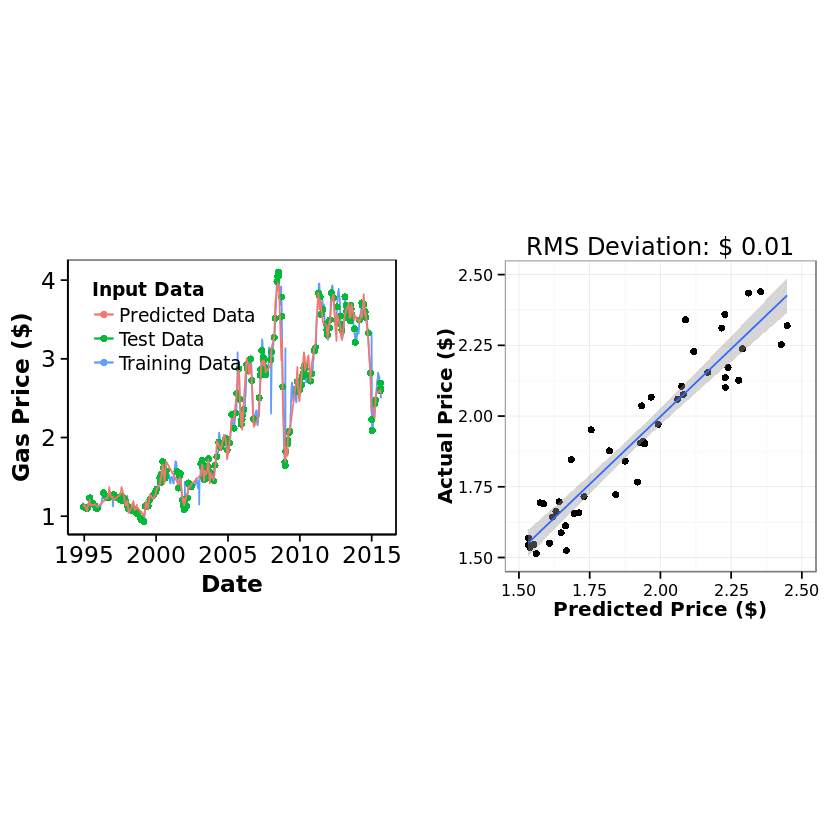

In [98]:
svm_model <- svm( GasPrice~.-Date-GasDate, data=trainsubdata, kernel='radial')

#Look at the model outputs
summary(svm_model)

#Predict the values for our test data
svm_predictedY <- predict(svm_model, testsubdata)

#Sore the data as a mean squared difference
svm_score<-mean((testsubdata$GasPrice-svm_predictedY)^2)
print(paste("MS Deviation:",as.character(svm_score)))

#Plot the model preditction to see how it looks
predData<-data.frame(testsubdata$Date,svm_predictedY)
colnames(predData)<-c("Date","GasPrice")

p1<-ggplot(trainsubdata,aes(Date,GasPrice))+geom_line(aes(color="Training Data"))+
  geom_point(data=testsubdata,aes(color="Test Data"))+
  labs(color="Input Data")+
  geom_line(data=predData,aes(color="Predicted Data"))+
  theme(legend.position=c(.3, .75),panel.border = element_rect(fill=NA,color="black", size=0.5, 
                                    linetype="solid"))+ 
  coord_fixed(ratio=2000)+xlab("Date")+ylab("Gas Price ($)")
  
predVact<-data.frame(testsubdata$GasPrice,predData$GasPrice)
colnames(predVact)<-c("pp","ap")
p2<-ggplot(predVact,aes(x=pp,y=ap))+geom_point()+ ylim(1.5,2.5)+ xlim(1.5,2.5)+
    geom_smooth(method=lm,   # Add linear regression line
                se=TRUE)+theme_bw()+    # Don't add shaded confidence region
    xlab("Predicted Price ($)") + ylab("Actual Price ($)")+ coord_fixed()+
    ggtitle(paste("RMS Deviation: $",sprintf("%.2f",svm_score)))

plot_grid(p1,p2)

The in-sample performance is significantly better than the linear model. We look at the out-of-sample performance.

[1] "RMS Deviation: $0.26"


Warning message:
In loop_apply(n, do.ply): Removed 11 rows containing missing values (stat_smooth).Warning message:
In loop_apply(n, do.ply): Removed 11 rows containing missing values (geom_point).

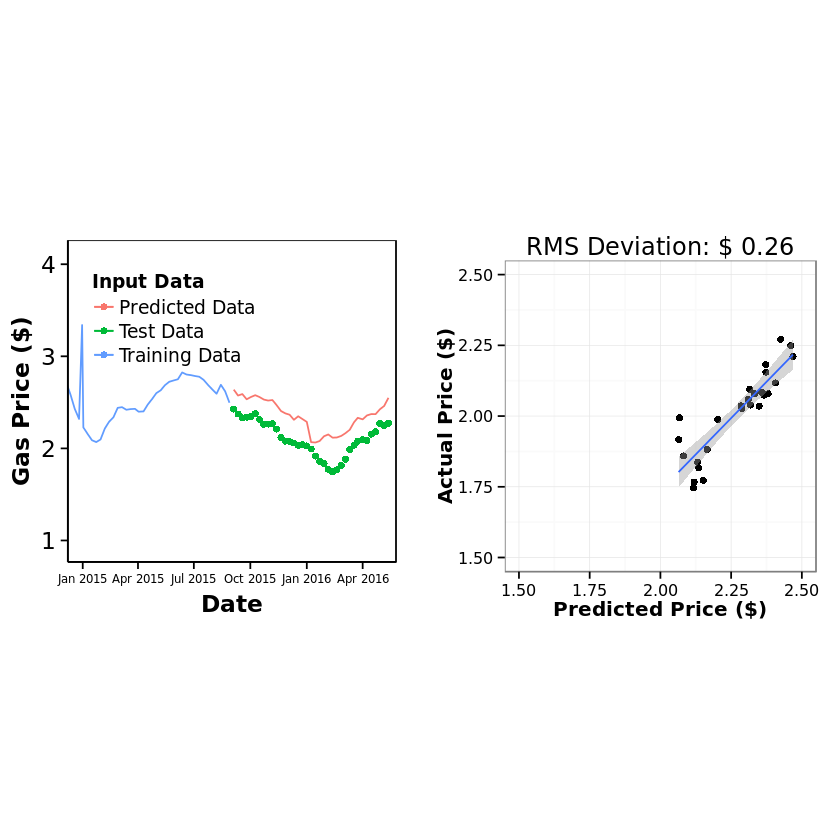

In [135]:
finalmodel <- svm(GasPrice~.-Date-GasDate, data=traindata, kernel='radial')

finalpredictedPrice <- predict(finalmodel, testdata)

finalpredtestData<-data.frame(testdata$Date,finalpredictedPrice)
colnames(finalpredtestData) <-c("Date","GasPrice")


p1<-ggplot(traindata,aes(Date,GasPrice))+geom_line(aes(color="Training Data"))+
  geom_point(data=testdata,aes(color="Test Data"))+
  labs(color="Input Data")+
  geom_line(data=finalpredtestData,aes(color="Predicted Data"))+
  theme(legend.position=c(.3, .75),panel.border = element_rect(fill=NA,color="black", size=0.5, 
                                    linetype="solid"),axis.text.x = element_text(size=7))+ 
  coord_fixed(ratio=150)+xlab("Date")+ylab("Gas Price ($)")+ 
  scale_x_date(limits=as.Date(c('2015-01-01','2016-05-01'),breaks=date_breaks(width="6 months")))

finalscore<-sqrt(mean((testdata$GasPrice-finalpredictedPrice)^2))
print(paste0("RMS Deviation: $",sprintf("%.2f",finalscore)))

predVact<-data.frame(finalpredictedPrice,testdata$GasPrice)
colnames(predVact)<-c("pp","ap")

p2<-ggplot(predVact,aes(x=pp,y=ap))+geom_point()+ ylim(1.5,2.5)+ xlim(1.5,2.5)+
    geom_smooth(method=lm,   # Add linear regression line
                se=TRUE)+theme_bw()+    # Don't add shaded confidence region
    xlab("Predicted Price ($)") + ylab("Actual Price ($)")+ coord_fixed()+
    ggtitle(paste("RMS Deviation: $",sprintf("%.2f",finalscore)))

plot_grid(p1,p2)

The out-of-sample performance looks like it has an unaccounted for bias.

## Models - Gradient Boosted Regression Tree

Finally we try the GBM to see how it performs.

,var,rel.inf
CrudePrice,CrudePrice,83.93061
GasStock,GasStock,14.24023
Week,Week,0.7284642
DaySupply,DaySupply,0.3851761
OilExports,OilExports,0.3021899
GasImports,GasImports,0.1754622
RefinerPerc,RefinerPerc,0.1513438
OilImports,OilImports,0.08651777


[1] "MS Deviation: 0.0109074694752203"


Warning message:
In loop_apply(n, do.ply): Removed 166 rows containing missing values (stat_smooth).Warning message:
In loop_apply(n, do.ply): Removed 166 rows containing missing values (geom_point).

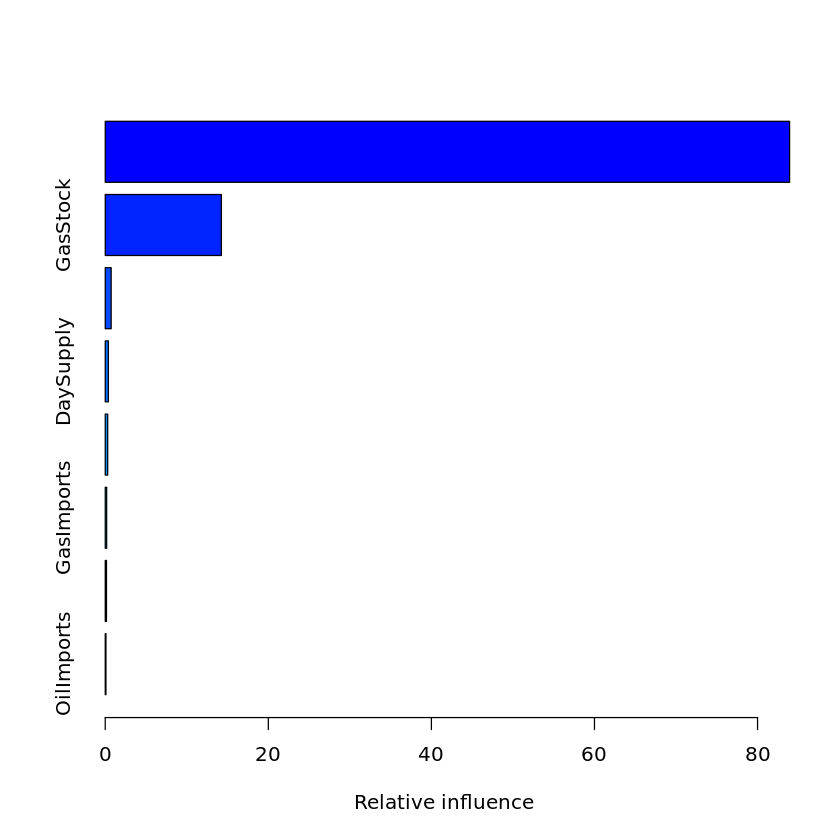

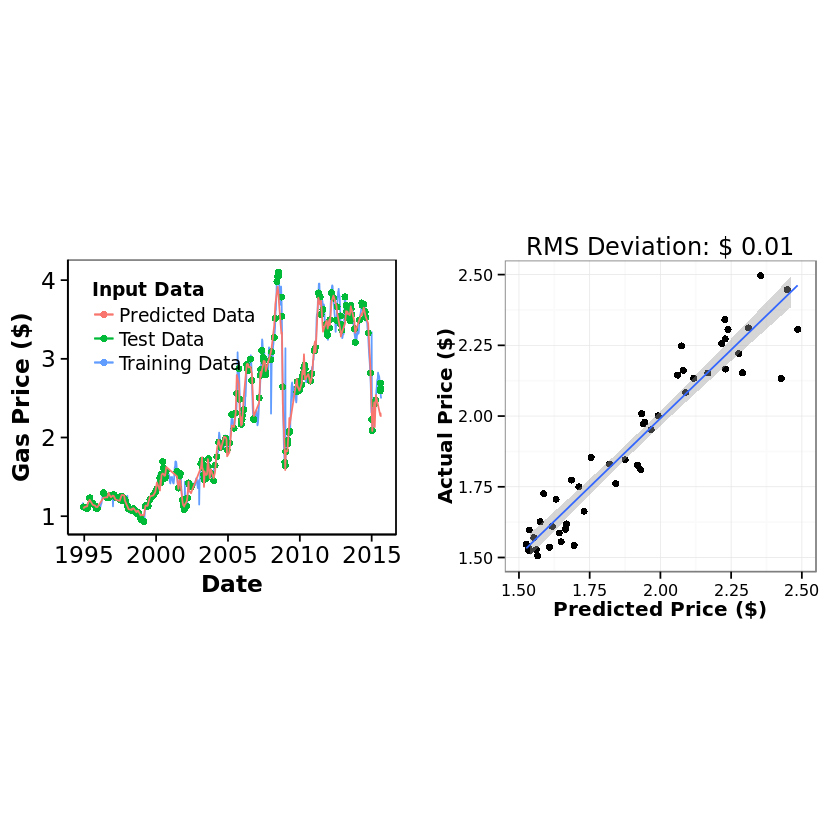

In [99]:
model <- gbm( GasPrice~.-Date-GasDate, data=trainsubdata, distribution="gaussian", interaction.depth=3,
            n.minobsinnode=10, n.trees=150,shrinkage=0.1)

summary(model)

predictedY <- predict(model, testsubdata, n.trees=model$n.trees)

score<-mean((testsubdata$GasPrice-predictedY)^2)
print(paste("MS Deviation:",as.character(score)))

predData<-data.frame(testsubdata$Date,predictedY)
colnames(predData)<-c("Date","GasPrice")

p1<-ggplot(trainsubdata,aes(Date,GasPrice))+geom_line(aes(color="Training Data"))+
  geom_point(data=testsubdata,aes(color="Test Data"))+
  labs(color="Input Data")+
  geom_line(data=predData,aes(color="Predicted Data"))+
  theme(legend.position=c(.3, .75),panel.border = element_rect(fill=NA,color="black", size=0.5, 
                                    linetype="solid"))+ 
  coord_fixed(ratio=2000)+xlab("Date")+ylab("Gas Price ($)")
  
predVact<-data.frame(testsubdata$GasPrice,predData$GasPrice)
colnames(predVact)<-c("pp","ap")
p2<-ggplot(predVact,aes(x=pp,y=ap))+geom_point()+ ylim(1.5,2.5)+ xlim(1.5,2.5)+
    geom_smooth(method=lm,   # Add linear regression line
                se=TRUE)+theme_bw()+    # Don't add shaded confidence region
    xlab("Predicted Price ($)") + ylab("Actual Price ($)")+ coord_fixed()+
    ggtitle(paste("RMS Deviation: $",sprintf("%.2f",score)))

plot_grid(p1,p2)


We see that the model predictions work fairly well. The most important variable is the crude oil spot price. However, there are a handful of other variables that also play a role in predicting the gas price. 

## GBM Model Optimization

Our next step is to optimize the model by tuning the hyperparameters.

In [110]:
#run the train function to optimize the hyperparameters
gbmFit1 <- train(GasPrice~.-Date-GasDate, data=traindata, method="gbm");
gbmFit1

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.7387            -nan     0.1000    0.1259
     2        0.6340            -nan     0.1000    0.1043
     3        0.5459            -nan     0.1000    0.0875
     4        0.4731            -nan     0.1000    0.0732
     5        0.4132            -nan     0.1000    0.0610
     6        0.3614            -nan     0.1000    0.0528
     7        0.3158            -nan     0.1000    0.0434
     8        0.2772            -nan     0.1000    0.0390
     9        0.2426            -nan     0.1000    0.0348
    10        0.2127            -nan     0.1000    0.0282
    20        0.0770            -nan     0.1000    0.0070
    40        0.0274            -nan     0.1000    0.0009
    60        0.0180            -nan     0.1000    0.0002
    80        0.0143            -nan     0.1000    0.0001
   100        0.0124            -nan     0.1000    0.0000
   120        0.0115            -nan     0.1000    0.0000
   140        

Stochastic Gradient Boosting 

1081 samples
  10 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 

Summary of sample sizes: 1081, 1081, 1081, 1081, 1081, 1081, ... 

Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared   RMSE SD      Rsquared SD
  1                   50      0.1592594  0.9731727  0.008263015  0.002277426
  1                  100      0.1301041  0.9807766  0.006664186  0.001822492
  1                  150      0.1223538  0.9829203  0.006466226  0.001692656
  2                   50      0.1299669  0.9811437  0.006512066  0.001698583
  2                  100      0.1099042  0.9862339  0.005927433  0.001390441
  2                  150      0.1028355  0.9879491  0.005722198  0.001207215
  3                   50      0.1169804  0.9845376  0.006200813  0.001456637
  3                  100      0.1006655  0.9884174  0.005811831  0.001184869
  3                  150      0.0957689  0.9895125  0.005633025  0.001071457

T

Now that we have the model optimized, we apply the optimized hyperparameters to the entire training model set, then use that to make predicitions on the final set of data. The predictions are shown below. We found that the SVM has an offset that just doesn't work. The linear model does better, but the Gradient Boosted descision tree does the best.

[1] "RMS Deviation: $0.07"


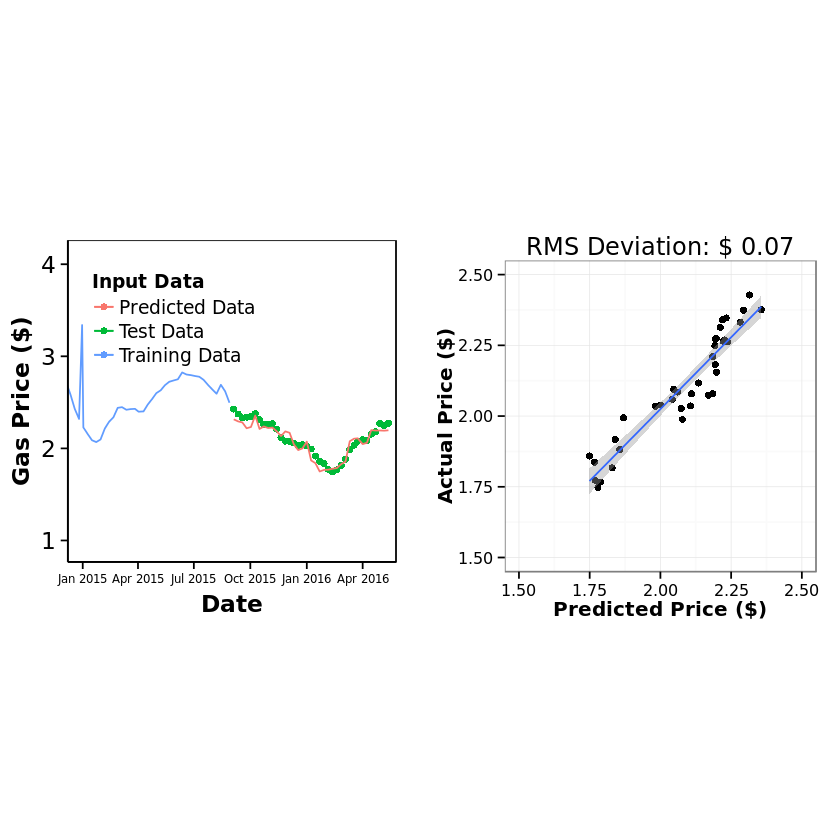

In [141]:

finalmodel <- gbm(GasPrice~.-Date-GasDate, data=traindata, distribution="gaussian", interaction.depth=4,
            n.minobsinnode=10, n.trees=200,shrinkage=0.05)


finalpredictedPrice <- predict(finalmodel, testdata, n.trees=finalmodel$n.trees)

finalpredtestData<-data.frame(testdata$Date,finalpredictedPrice)
colnames(finalpredtestData) <-c("Date","GasPrice")


p1<-ggplot(traindata,aes(Date,GasPrice))+geom_line(aes(color="Training Data"))+
  geom_point(data=testdata,aes(color="Test Data"))+
  labs(color="Input Data")+
  geom_line(data=finalpredtestData,aes(color="Predicted Data"))+
  theme(legend.position=c(.3, .75),panel.border = element_rect(fill=NA,color="black", size=0.5, 
                                    linetype="solid"),axis.text.x = element_text(size=7))+ 
  coord_fixed(ratio=150)+xlab("Date")+ylab("Gas Price ($)")+ 
  scale_x_date(limits=as.Date(c('2015-01-01','2016-05-01'),breaks=date_breaks(width="6 months")))

finalscore<-sqrt(mean((testdata$GasPrice-finalpredictedPrice)^2))
print(paste0("RMS Deviation: $",sprintf("%.2f",finalscore)))

predVact<-data.frame(finalpredictedPrice,testdata$GasPrice)
colnames(predVact)<-c("pp","ap")

p2<-ggplot(predVact,aes(x=pp,y=ap))+geom_point()+ ylim(1.5,2.5)+ xlim(1.5,2.5)+
    geom_smooth(method=lm,   # Add linear regression line
                se=TRUE)+theme_bw()+    # Don't add shaded confidence region
    xlab("Predicted Price ($)") + ylab("Actual Price ($)")+ coord_fixed()+
    ggtitle(paste("RMS Deviation: $",sprintf("%.2f",finalscore)))

plot_grid(p1,p2)

Final Notes
===
So the model works fairly well now. I am off by an average of around $0.11 on the predicted price of gas. The model follows the larger trends and swings in the data.